#### Code for the Poster Contribution A 133 "Go- no-go decisions based on gradually revealed visual information" at V-VSS 2021
##### by Clara Kuper
##### April 2021

In this code, I will review and discuss the data from a pilot experiment. Substantial parts of this analysis are 
presented at V-VSS 2021 in poster session A, on Saturday, the 22nd of May 2021. This notebook includes more analysis and 
information than included in the poster. Figures used in the poster are marked as 
"V-VSS 2021 Figure" and the corresponding analysis is marked as "V-VSS 2021 Analysis"

In this notebook, I will follow these steps:

0. Load the needed libraries and data files

1. review the data 
    
    a. describe size, structure
    
    b. show basic behavioural measurements (V-VSS 2021 Figures & Code)
    
    
2. describe different strategies to solve the task
    
    a. explain how hit probability was computed
    
    b. compare ideal observers using different strategies
    
    c. fit linear models to models the response type (go/ no-go). (V-VSS 2021 Figures & Code)
    
    d. fit linear models to the reaction time (V-VSS 2021 Figures & Code)
    
    
3. describe the time windows that had an influence on the response (V-VSS 2021 Figures & Code)
    
    a. modeled forwards, from the start of each trial
    
    b. modeled backwards, from the response in each trial
    
    
5. describe 3 mechanisms, based on drift diffusion models, and compare their simulated output to 3. (V-VSS 2021 Figures & Code)

A few words about this notebook:

As you will notice, this notebook contains very few lines of code. Instead, it executes functions and scipts that  are stored in the folder "utils". If you are interested in any specific procedures used here, please look them up there.

The linear response models will are fitted directly in the notebook.

In [1]:
##################################
# import the necessary libraries #
##################################

# functions for plots
import utils.plotting as plotting
# functions for diverse tasks
import utils.utils as utils
from utils.drift_diffusion_analysis import BoundCollapsingExponentialDelay, FirstValDrift, ThreshDrift, ContinuousUpdate
# functions for drift diffusion models
import utils.drift_diffusion_analysis as dda



import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import os
import scipy.stats as stats

############
# import R #
############
# we will use the R framework to fit mixed effect models
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'
# pymer is built on the lme4 package in R
from pymer4.models import Lmer, Lm

##############
# data paths #
##############
path_data = './data/'
path_models = './models/'

############## 
# data files #
##############
# wide df
df_short = pd.read_csv(path_data+'dataframe_short.csv', sep = ',')
# long df
df_long = pd.read_csv(path_data+'dataframe_long.csv', sep = ',')

## when fitting reaction times, we will need only the trial with "go" responses
responses = [0,1]
ldf_nogo, ldf_go = utils.split_df(df_long, 'goResp', responses)
sdf_nogo, sdf_go = utils.split_df(df_short, 'goResp', responses)

# print some information about the data frames:
print(f"The long df has {df_long.shape[1]} columns and {df_long.shape[0]} rows")
print(f"The short df has {df_short.shape[1]} columns and {df_short.shape[0]} rows")
print(f"The short go df has {sdf_go.shape[0]} rows and the short nogo df has {sdf_nogo.shape[0]} rows")

The long df has 17 columns and 57534 rows
The short df has 33 columns and 9589 rows
The short go df has 4750 rows and the short nogo df has 4839 rows


## 1. Data Review
### Introduction to the task:
The observer is asked to decide if a moving stimulus (attacker) will intercept or pass a target range (goal) on the screen.
The goal is revealed gradually while the attacker is moving, by showing dots (samples) that are sampled uniformly 
from the goal's position. 6 samples are shown over a trial duration of 1 second.
A response has to be given before the attacker reaches the goal, either by moving the hand from the keyboard to 
the screen and touching the estimated location of the goal (go), or by keeping the hand on the keyboard (no-go).

Below, I include an illustration of one trial, which can also be found in the "figures" folder.
![TrialLocal](./figures/example_trial.gif "Example Trial")

### Introduction to the data structure:

The "short" data frame has one row for each trial. Properties of individual samples are stored in seperate columns

The "long" data frame has one row for each sample (six rows per trial), where properties for different samples are stored
in the same column.

The most important column names for this analysis are:

1. subject: the ID for each observer [o1, o2, o3, o4]
2. session: the session ID [1 - 3]
4. indTrial: a unique ID for each trial (only in the long data frame, corresponds to the index in the short data frame)
5. rea_time: reaction time in seconds (time from go signal till the movement to the screen started)
6. goResp: if observers produced a "go" or "no-go" response [1,0]
7. hitGoal: if the current trial was a hit or a pass trial [1,0]
8. answer: if the response was correct or incorrect [1,0]
9. response_cat: the response category [HIT, MISS, CORRECT_REJECTION, FALSE_ALARM]
10. sampleTimeMsGo: the time in ms at which a sample appeared relative to the go signal (with extensions _01 - _06 for the short data frame)
11. samplePosDegAtt: the distance from the attacker to the current sample in degree visual angle (with extensions for the short data frame)
12. sampleProbHit: the probability that the trial is a "Hit", computed from the current sample (with extensions for the short data frame)
13. sampleAccprobHit: the probability that the trial is a "Hit", computed from all samples up to (and including) the current sample (with extensions)
14. sampleID: the order in which samples were shown (only for the long data frame) [0 - 6]

Other columns are variations of the above, with different time units or expressed relatively to a different time in the 
experiment (e.g. sampleTimeSecResp is the time of sample appearance in seconds relative to the response onset).

In [2]:
########################################
# some summaries generated with pandas #
# to get an overview of the data       #
########################################
# proportion of go/ no-go responses
summary_bSS = df_short.groupby(['subject', 'session']).describe().goResp
summary_bSS

count      mean       std  min  25%  50%  75%  max
subject session                                                    
o1      1        800.0  0.606250  0.488886  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.522500  0.499806  0.0  0.0  1.0  1.0  1.0
        3        799.0  0.491865  0.500247  0.0  0.0  0.0  1.0  1.0
o2      1        796.0  0.430905  0.495514  0.0  0.0  0.0  1.0  1.0
        2        799.0  0.415519  0.493120  0.0  0.0  0.0  1.0  1.0
        3        797.0  0.432873  0.495785  0.0  0.0  0.0  1.0  1.0
o3      1        800.0  0.463750  0.498996  0.0  0.0  0.0  1.0  1.0
        2        798.0  0.431078  0.495538  0.0  0.0  0.0  1.0  1.0
        3        800.0  0.441250  0.496847  0.0  0.0  0.0  1.0  1.0
o4      1        800.0  0.640000  0.480300  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.531250  0.499335  0.0  0.0  1.0  1.0  1.0
        3        800.0  0.536250  0.498996  0.0  0.0  1.0  1.0  1.0

every subject ran 3 session with ~800 successfully completed trials in each. The maximum number of excluded trials was 
4 in one session.

Subjects generated between 60 - 40 % go responses.

In [3]:
# proportion of correct/ incorrect responses by subject, session and condition
summary_a_bSSH = df_short.groupby(['subject','session', 'hitGoal']).describe().answer
summary_a_bSSH

count      mean       std  min  25%  50%  75%  max
subject session hitGoal                                                    
o1      1       0        400.0  0.672500  0.469889  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.885000  0.319421  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.820000  0.384669  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.865000  0.342152  0.0  1.0  1.0  1.0  1.0
        3       0        399.0  0.892231  0.310478  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.875000  0.331133  0.0  1.0  1.0  1.0  1.0
o2      1       0        400.0  0.935000  0.246835  0.0  1.0  1.0  1.0  1.0
                1        396.0  0.800505  0.400126  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.957500  0.201980  0.0  1.0  1.0  1.0  1.0
                1        399.0  0.789474  0.408194  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.937500  0.242365  0.0  1.0  1.0  1.0  1.0
                1        397.0  0.806045  0.395893  0.0  1.0  1.0  1.0  1.0
o3      1       0        400.0  0.827500  0.378288  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.755000  0.430626  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.897500  0.303685  0.0  1.0  1.0  1.0  1.0
                1        398.0  0.761307  0.426822  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.912500  0.282920  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.795000  0.404207  0.0  1.0  1.0  1.0  1.0
o4      1       0        400.0  0.615000  0.487205  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.895000  0.306937  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.825000  0.380443  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.887500  0.316376  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.845000  0.362358  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.917500  0.275470  0.0  1.0  1.0  1.0  1.0

Responses are mostly correct.

In [4]:
# response times
summary_r_bSS = df_short.groupby(['subject','session','goResp']).describe().rea_time
summary_r_bSS

count      mean       std       min       25%  \
subject session goResp                                                  
o1      1       0         0.0       NaN       NaN       NaN       NaN   
                1       485.0  0.520437  0.086453  0.317108  0.450144   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       418.0  0.529800  0.087098  0.308625  0.466004   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       393.0  0.520102  0.080500  0.340964  0.457889   
o2      1       0         0.0       NaN       NaN       NaN       NaN   
                1       343.0  0.518824  0.074193  0.349766  0.466352   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       332.0  0.561288  0.068841  0.383147  0.514054   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       345.0  0.535802  0.068189  0.408158  0.483221   
o3      1       0         0.0       NaN       NaN       NaN       NaN   
                1       371.0  0.466831  0.104657  0.258133  0.387271   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       344.0  0.462944  0.093811  0.290775  0.391250   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       353.0  0.477539  0.090869  0.299756  0.407888   
o4      1       0         0.0       NaN       NaN       NaN       NaN   
                1       512.0  0.646261  0.059979  0.433151  0.608061   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       425.0  0.619411  0.052415  0.483152  0.582845   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       429.0  0.616941  0.052586  0.466287  0.582670   

                             50%       75%       max  
subject session goResp                                
o1      1       0            NaN       NaN       NaN  
                1       0.516454  0.583534  0.757948  
        2       0            NaN       NaN       NaN  
                1       0.516490  0.591050  0.758108  
        3       0            NaN       NaN       NaN  
                1       0.516084  0.582689  0.724802  
o2      1       0            NaN       NaN       NaN  
                1       0.499829  0.565983  0.724800  
        2       0            NaN       NaN       NaN  
                1       0.557913  0.607766  0.758028  
        3       0            NaN       NaN       NaN  
                1       0.516466  0.566340  0.774631  
o3      1       0            NaN       NaN       NaN  
                1       0.457863  0.532976  0.766424  
        2       0            NaN       NaN       NaN  
                1       0.450177  0.518973  0.766537  
        3       0            NaN       NaN       NaN  
                1       0.474843  0.533026  0.758314  
o4      1       0            NaN       NaN       NaN  
                1       0.649628  0.691437  0.774645  
        2       0            NaN       NaN       NaN  
                1       0.624387  0.658097  0.774663  
        3       0            NaN       NaN       NaN  
                1       0.616244  0.649588  0.774639

We only have reaction times for "go" responses, but not for "no-go" responses.
Observer seem to differ in their response times.

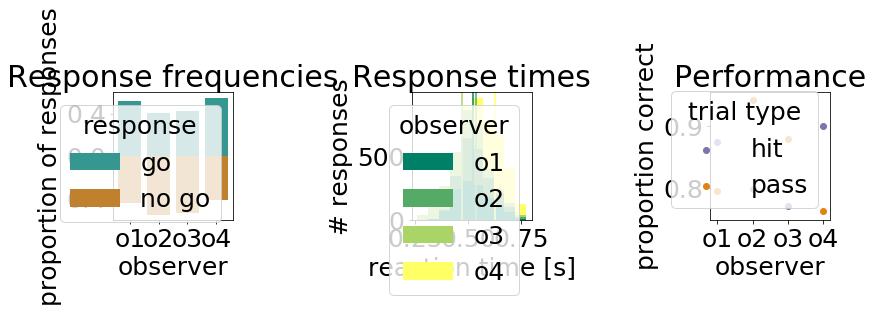

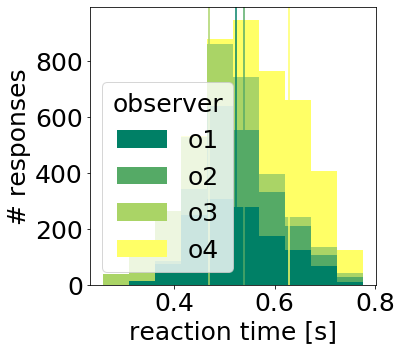

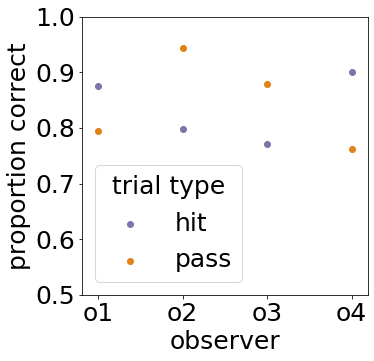

In [5]:
# Build a figure for response characteristics
rts, p_hit, p_pass, obs = plotting.make_summary_plot(df_short)

#********************#
# V-VSS 2021 figures #
#********************#
# Figure 1: Reaction Times 
plotting.VVSS_fig1_plot(df_short, rts, obs)


# Figure 2: performance 
plotting.VVSS_fig2_plot(p_hit, p_pass, obs)



## 2. Response strategies
### Estimating the probability of a "hit"

Due to the random sampling from the goal's true location, samples can appear close to the attacker,
(suggesting a "hit" trial), even though the ground truth is a "pass" trial. Vice versa, samples can 
also appear far away from the attacker (suggesting a "pass" trial), even though the current trial is
a hit trial.

The distance between attacker and target can also be expressed in terms of a "hit probability", where
a distance between attacker and target that exceeds the goal's width results in a probability of 0, and
very small distances result in a probability close to one.


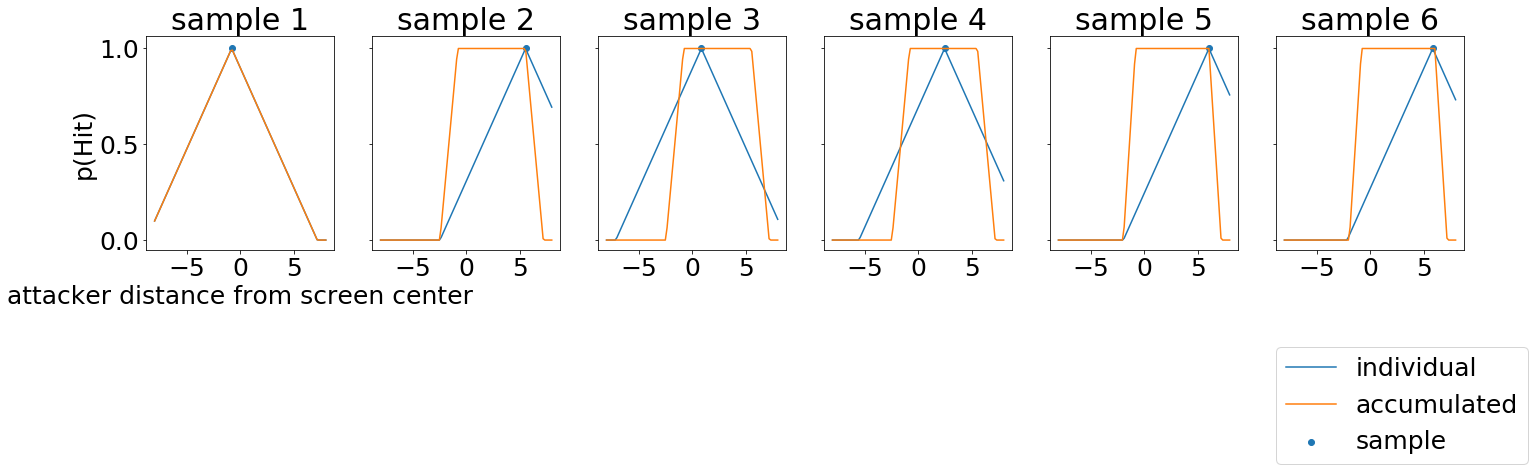

In [6]:
# Visualization of Hit Probability
plotting.show_hit_probability(df_long)


Shown above is the probability that the current trial is a "hit" or a "pass" trial (y axis), for different
attacker positions (x axis). 
6 samples are presented, their position is marked with a dot.

We compare two different probabilities. The "individual" probability is computed based only on the
most recently shown sample.
The "accumulated" probability is computed based on all currently presented samples.

We can see that for accumulated probabilities, samples shown between 2 known samples don't change the 
probability of a "hit". We also see, that the range of the goal covered by previous samples changes the steepness
of the drop in probability.

### Strategies to solve the task
We will compare different strategies to estimate the goal's true location:
    
1. the responses are evaluated on a sample-by-sample basis.
2. the responses are based on an average of individual samples.
3. the responses are based on a combined evaluation of all presented samples.
    
We will show, how performance evolves with each sample for the 3 strategies presented above.
Human observers perform this task under time pressure and will generate a response after ~500 ms, which corresponds to
3 presented samples.

The assumption made for this case is that observers will respond "go", when the probability of a hit
is larger than 0.5 and 'no-go' otherwise.

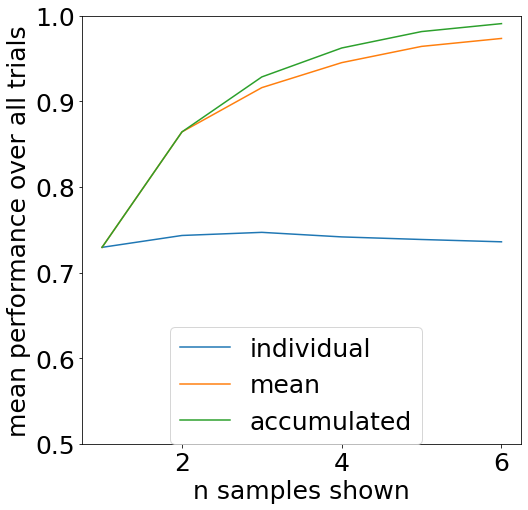

In [7]:
# run function to get predicted performances for each observer
plotting.show_mean_performance(df_long, df_short)

While the performance of the "individual" observer does not change with more samples. The performance of the
"mean" and the "accumulated" observers do increase over time in a highly comparable fashion, the accumulated observer 
achieves slightly better performance after the third sample.

The performance of the individual ideal observer is lower than performance of our human observers. Therefore, it is 
likely that human observers use a strategy where the information from different samples is combined. Differentiating 
between accumulating evidence and a linear combination of samples is difficult in this task, because both strategies
result in similar performance. The linear regression models I will compute in the next step are analogous to an observer
using the "mean" strategy, with different weights in each time window.
 
With the linear models, I want to demonstrate two things:
1. there is a significant interaction between the time when a sample was shown and the probability of a hit indicated 
by that sample that influences the response (go/ no-go) and the reaction time.
2. this interaction is non-linear. Therefore, it makes sense to estimate the slope of each sample individually.

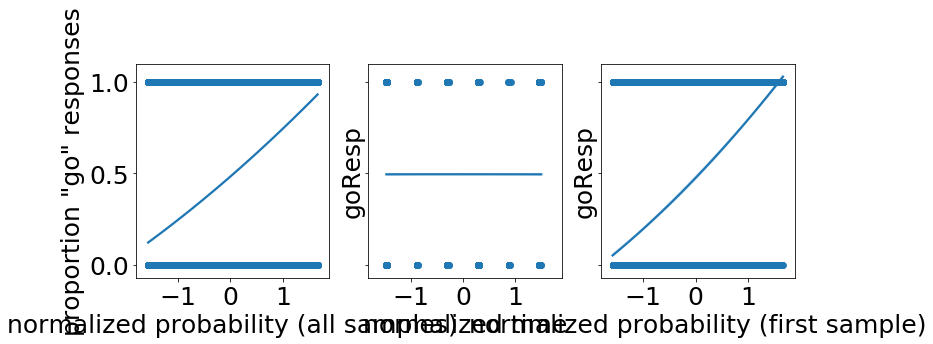

In [8]:
####################
# normalizing data #
####################
# Currently, probabilities range between 0 and 1, and time ranges between 0 and 840 ms. we want to 
# normalize both values to mean 0 and unit variance.

ldf_normal = utils.normalize_df(df_long.copy(), ['sampleTimeSecGo', 'sampleProbHit'])
sdf_normal = utils.normalize_df(df_short.copy(), ['sampleProbHit_01', 'sampleProbHit_02', 'sampleProbHit_03',
                                                  'sampleProbHit_04', 'sampleProbHit_05', 'sampleProbHit_06'])
# TODO: put in function
# show the normalized values in a plot
plotting.visualize_response_predictors(ldf_normal, sdf_normal)


In [9]:
#####################################
# Fitting models with time variable #
#####################################
# fitting the full model
# we use R in the background here, because we are not aware of an established framework to fit mixed logisitc regressions
# in python.
responses_mfull = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 + sampleProbHit + sampleTimeSecGo | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_mfull.fit()

boundary (singular) fit: see ?isSingular 

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1+sampleProbHit+sampleTimeSecGo|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31457.696 	 AIC: 62935.392

Random effects:

                    Name    Var    Std
subject      (Intercept)  0.114  0.337
subject    sampleProbHit  0.005  0.073
subject  sampleTimeSecGo  0.001  0.029

                   IV1              IV2   Corr
subject    (Intercept)    sampleProbHit -0.791
subject    (Intercept)  sampleTimeSecGo -0.982
subject  sampleProbHit  sampleTimeSecGo  0.892

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.050,-0.381,0.282,0.169,0.952,0.683,1.325,0.488,0.406,0.570,-0.293,0.769,
sampleProbHit,1.237,1.162,1.312,0.038,3.444,3.195,3.713,0.775,0.762,0.788,32.250,0.000,***
sampleTimeSecGo,0.013,-0.021,0.048,0.018,1.013,0.979,1.049,0.503,0.495,0.512,0.756,0.449,
sampleProbHit:sampleTimeSecGo,-0.229,-0.251,-0.207,0.011,0.795,0.778,0.813,0.443,0.437,0.449,-20.056,0.000,***


In [10]:
# the full model produces singluar fits (indication for too many random effects).
# we will reduce the random effects in the next model
# The random slope for time has the smallest variance (explains little variance in the data)
# Therefore, we remove this random effect for the next model

responses_m1 = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 + sampleProbHit | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_m1.fit()

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.107 	 AIC: 62938.215

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.049,-0.379,0.280,0.168,0.952,0.684,1.324,0.488,0.406,0.570,-0.293,0.769,
sampleProbHit,1.235,1.161,1.310,0.038,3.440,3.193,3.706,0.775,0.761,0.788,32.482,0.000,***
sampleTimeSecGo,0.013,-0.007,0.032,0.010,1.013,0.993,1.032,0.503,0.498,0.508,1.286,0.198,
sampleProbHit:sampleTimeSecGo,-0.224,-0.246,-0.202,0.011,0.799,0.782,0.817,0.444,0.439,0.450,-19.850,0.000,***


In [11]:
# The model now converges. We will compare it to a model that has only a random intercept, and no random 
# slopes, because the variance explained by the random slopes for probability is also low.
responses_m2 = Lmer('goResp ~ sampleProbHit * sampleTimeSecGo + (1 | subject)', 
                       data = ldf_normal, family = 'binomial')
responses_m2.fit()

Formula: goResp~sampleProbHit*sampleTimeSecGo+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31478.503 	 AIC: 62967.006

Random effects:

                Name    Var    Std
subject  (Intercept)  0.109  0.331

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.042,-0.367,0.283,0.166,0.959,0.693,1.327,0.489,0.409,0.570,-0.253,0.800,
sampleProbHit,1.232,1.210,1.255,0.011,3.429,3.353,3.506,0.774,0.770,0.778,107.806,0.000,***
sampleTimeSecGo,0.012,-0.007,0.031,0.010,1.012,0.993,1.032,0.503,0.498,0.508,1.252,0.211,
sampleProbHit:sampleTimeSecGo,-0.224,-0.246,-0.202,0.011,0.799,0.782,0.817,0.444,0.439,0.450,-19.831,0.000,***


To compare the likelihoods of the two models, we can use a chi-square test
the second model (responses_m2) is our "null-model", because it assumes that the random slopes for probability
are zero. The first model (responses_m1) has a non-zero random slope. 

In [12]:
# the test statistic is the difference between the (-2 * REML log Likelihoods of the models)
TS = -2*responses_m2.logLike - -2*responses_m1.logLike 
# compute the p-value as a chi-squared distribution
pval = 0.5 * (1 - stats.chi2.cdf(TS, 1)) + 0.5 * (1 - stats.chi2.cdf(TS, 2))
# print the p-value
print(f"The p-value of the significance test is {pval}.")

The p-value of the significance test is 4.301762845937418e-08.


The p-value is below 0.05, so we should reject the null hypothesis and assume that there is a random slope for probability.
This means, that our model of choice is model responses_m1. In this model, we have seen that the only significant terms 
were the main effect of probability and the interaction between probability and time. 
We will fit a final model without the insignificant effects.

In [13]:
##################################################
# fitting the final model with time as predictor #
##################################################
responses_linearmodel = Lmer('goResp ~ sampleProbHit + sampleProbHit:sampleTimeSecGo + (1 + sampleProbHit | subject)',
                    data = ldf_normal, family = 'binomial')
responses_linearmodel.fit()

Formula: goResp~sampleProbHit+sampleProbHit:sampleTimeSecGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.935 	 AIC: 62937.870

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.048,-0.376,0.279,0.167,0.953,0.687,1.322,0.488,0.407,0.569,-0.289,0.772,
sampleProbHit,1.235,1.161,1.309,0.038,3.439,3.193,3.704,0.775,0.762,0.787,32.629,0.000,***
sampleProbHit:sampleTimeSecGo,-0.223,-0.245,-0.201,0.011,0.800,0.782,0.818,0.444,0.439,0.450,-19.814,0.000,***


This analysis reveals, that there is a significant interaction between probability for a hit and time. The interaction is
negative. That means, the later a sample was presented the lower was it's impact of the response. However, this analysis
assumes that the interaction is linear.
We will do a simple visual test of this assumption: we will plot the relationship between response (go/ no-go) and 
probability individually for each sample and overlay the relationship estimated by our current model.

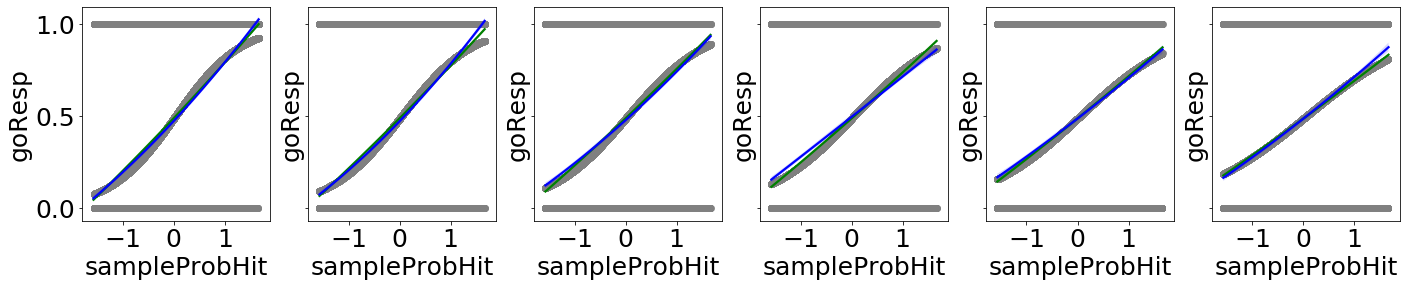

In [14]:
# run the function to plot predictions vs. individual time windows
plotting.plot_prediction_comparison(ldf_normal, responses_linearmodel, 'goResp')

The linear interaction seems to match the responses. But we have to wonder, why there is still a positive correlation 
between hit probability and response with sample 6. We would not expect this relationship, because sample 6 was shown 
after a response was generated. So possibly, we see the positive relationship between hit probability and response only 
because the hit probability of sample 6 correlates with the hit probability of sample 1. 

We can use a quick correlation test to check for this correlation.

the covariance between sample 1 and sample 6 is [[0.09434889 0.03699297]
 [0.03699297 0.09555955]].


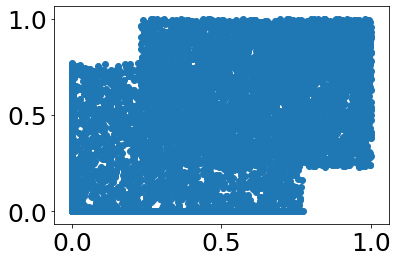

In [15]:
# compute the covariance
cov_s1_s2 = np.cov(df_short.sampleProbHit_01, df_short.sampleProbHit_06)
print(f"the covariance between sample 1 and sample 6 is {cov_s1_s2}.")

# plot the correlation
plt.scatter(df_short.sampleProbHit_01, df_short.sampleProbHit_06);

The plot shows that we have 2 different regions - one region with higher values of hit probability 
and one region with lower hit probability, those regions likely correspond to hit and pass trials.
However, within these regions, there seems to be no clear correlation between the hit probabilities 
of sample 1 and sample 6. This motivates us to include the variable "hitGoal" into the model below:

In [16]:
# compute if one sample can be used to predict the other
sampleCorr = Lm('sampleProbHit_06 ~ sampleProbHit_01 + hitGoal', data = df_short)
sampleCorr.fit()

Formula: sampleProbHit_06~sampleProbHit_01+hitGoal

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 9589	 R^2: 0.402	 R^2_adj: 0.402

Log-likelihood: 117.085 	 AIC: -228.169	 BIC: -206.664

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.291,0.282,0.300,0.005,9586,63.538,0.000,***
sampleProbHit_01,-0.008,-0.028,0.012,0.010,9586,-0.792,0.429,
hitGoal,0.395,0.383,0.407,0.006,9586,63.335,0.000,***


The variable "hitGoal" predicts the probability of a hit. When controlling for it, the sample 
probability itself does not predict the probability of the next sample.

To allow for varying correlation between the hit probability of each sample and the outcome of each
trial, we now fit a model that takes the probability of each sample as individual predictor.
This can be seen as equivalent to introducing random slopes for samples IDs in the model above, while
at the same time eliminating time as a predictor with a potential main effect. In contrast to defining
random slopes for each sample, we include them explicitly as fixed effects. 

The variable hitGoal is included to prevent spurious correlation between probabilities.
THe random effects are restricted to a random intercept for each subject, because including random slopes for
each sample would result in singular fits. 

In [17]:
################################################################ 
# Fitting responses with individual regressors for each sample #
#################################################################
responsesSample_full = Lmer('goResp ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 + hitGoal +(1|subject)', 
                            data = sdf_normal, family = 'binomial')
responsesSample_full.fit()


Formula: goResp~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+hitGoal+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3261.711 	 AIC: 6541.421

Random effects:

                Name    Var    Std
subject  (Intercept)  0.353  0.594

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.604,-1.202,-0.005,0.305,0.547,0.301,0.995,0.354,0.231,0.499,-1.977,0.048,*
sampleProbHit_01,1.235,1.149,1.321,0.044,3.438,3.156,3.746,0.775,0.759,0.789,28.268,0.000,***
sampleProbHit_02,1.067,0.983,1.151,0.043,2.905,2.671,3.160,0.744,0.728,0.760,24.881,0.000,***
sampleProbHit_03,0.461,0.380,0.542,0.041,1.586,1.462,1.719,0.613,0.594,0.632,11.150,0.000,***
sampleProbHit_04,-0.030,-0.111,0.051,0.041,0.970,0.895,1.052,0.492,0.472,0.513,-0.727,0.467,
sampleProbHit_05,-0.022,-0.103,0.058,0.041,0.978,0.902,1.060,0.494,0.474,0.515,-0.547,0.584,
sampleProbHit_06,0.031,-0.049,0.111,0.041,1.031,0.952,1.117,0.508,0.488,0.528,0.758,0.448,
hitGoal,1.034,0.787,1.280,0.126,2.812,2.198,3.598,0.738,0.687,0.783,8.222,0.000,***


In [18]:
##############
# VVSS Model #
##############
responsesSample_linearmodel = Lmer('goResp ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + hitGoal +(1|subject)',
                                   data = sdf_normal, family = 'binomial')
responsesSample_linearmodel.fit()

Formula: goResp~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+hitGoal+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3262.409 	 AIC: 6536.818

Random effects:

                Name    Var    Std
subject  (Intercept)  0.353  0.594

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.589,-1.181,0.002,0.302,0.555,0.307,1.002,0.357,0.235,0.501,-1.952,0.051,.
sampleProbHit_01,1.234,1.148,1.320,0.044,3.435,3.153,3.742,0.775,0.759,0.789,28.261,0.000,***
sampleProbHit_02,1.067,0.983,1.151,0.043,2.907,2.672,3.161,0.744,0.728,0.760,24.901,0.000,***
sampleProbHit_03,0.461,0.380,0.542,0.041,1.586,1.462,1.720,0.613,0.594,0.632,11.154,0.000,***
hitGoal,1.006,0.833,1.178,0.088,2.734,2.300,3.249,0.732,0.697,0.765,11.409,0.000,***


After controlling for the trial condition and allowing individual slopes for each sample, we can see 
that only sample 1-3 are correlated with the response type. In the following step, we want to visualize 
this correlation. 

Samples 4-6 will be included in the plot to illustrate the differences in the slope. Beacause the estimates
of the slope did not change much between the full model and the final model, we will simply plot 
the results from the full model in order to get slopes for samples 4-6.

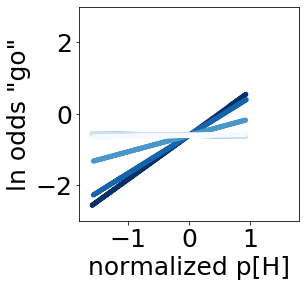

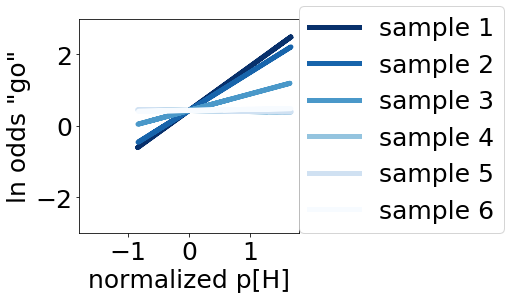

In [19]:
###############
# VVSS Figure #
###############
plotting.VVSS2021_fig3_plot(sdf_normal, responsesSample_full)

In the next step, we will fit linear models to reaction time, following the same steps as above.
Reaction times only exist for trials where a "go" response was generated. Therefore, we will use the "go"
dataset generated above.

In [20]:
#################
# Normalization #
#################
# normalize the long and the short "go" dataset
ldf_go_normal = utils.normalize_df(ldf_go.copy(), ['sampleTimeSecGo', 'sampleProbHit'])
sdf_go_normal = utils.normalize_df(sdf_go.copy(), ['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03',
                                                   'sampleProbHit_04','sampleProbHit_05','sampleProbHit_06'])

In [21]:
###########################################
# fit the models with linear interactions #
# # # # between probability & time  # # # #
############################################
rts_mfull = Lmer('rea_time ~ sampleProbHit * sampleTimeMsGo + (1 + sampleProbHit + sampleTimeMsGo | subject)',
                 data = ldf_go_normal)
rts_mfull.fit()

boundary (singular) fit: see ?isSingular 

Formula: rea_time~sampleProbHit*sampleTimeMsGo+(1+sampleProbHit+sampleTimeMsGo|subject)

Family: gaussian	 Inference: parametric

Number of observations: 28500	 Groups: {'subject': 4.0}

Log-likelihood: 32197.161 	 AIC: -64394.321

Random effects:

                    Name    Var    Std
subject      (Intercept)  0.008  0.088
subject    sampleProbHit  0.000  0.001
subject   sampleTimeMsGo  0.000  0.000
Residual                  0.006  0.078

                   IV1             IV2   Corr
subject    (Intercept)   sampleProbHit -0.100
subject    (Intercept)  sampleTimeMsGo  0.999
subject  sampleProbHit  sampleTimeMsGo -0.067

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.541,0.455,0.627,0.044,0.925,12.344,0.061,.
sampleProbHit,-0.013,-0.015,-0.011,0.001,9.685,-13.315,0.000,***
sampleTimeMsGo,-0.000,-0.000,0.000,0.000,3.586,-0.927,0.412,
sampleProbHit:sampleTimeMsGo,0.000,0.000,0.000,0.000,28486.470,11.980,0.000,***


This model again produces a singular fit. Therefore, we want to exclude some random effects.
Both the random slopes for sample probability and for sample time explain very little variance.
We will exclude them both in one step here.

In [22]:
# first reduction step
rts_r1 = Lmer('rea_time ~ sampleProbHit + sampleTimeMsGo+ sampleProbHit:sampleTimeMsGo + (1|subject)', data = ldf_go_normal)
rts_r1.fit()

Formula: rea_time~sampleProbHit+sampleTimeMsGo+sampleProbHit:sampleTimeMsGo+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 28500	 Groups: {'subject': 4.0}

Log-likelihood: 32196.923 	 AIC: -64393.846

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.066
Residual               0.006  0.078

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.541,0.476,0.606,0.033,3.002,16.413,0.000,***
sampleProbHit,-0.013,-0.015,-0.011,0.001,28493.044,-15.078,0.000,***
sampleTimeMsGo,-0.000,-0.000,0.000,0.000,28493.001,-1.006,0.314,
sampleProbHit:sampleTimeMsGo,0.000,0.000,0.000,0.000,28493.004,11.926,0.000,***


This model suggests, that there is a significant main effect of time, probability and a significant interaction of 
time and probability. Again, we want to check, if the predictions made by our model also fit the predictions we would 
make when fitting all time windows individually:

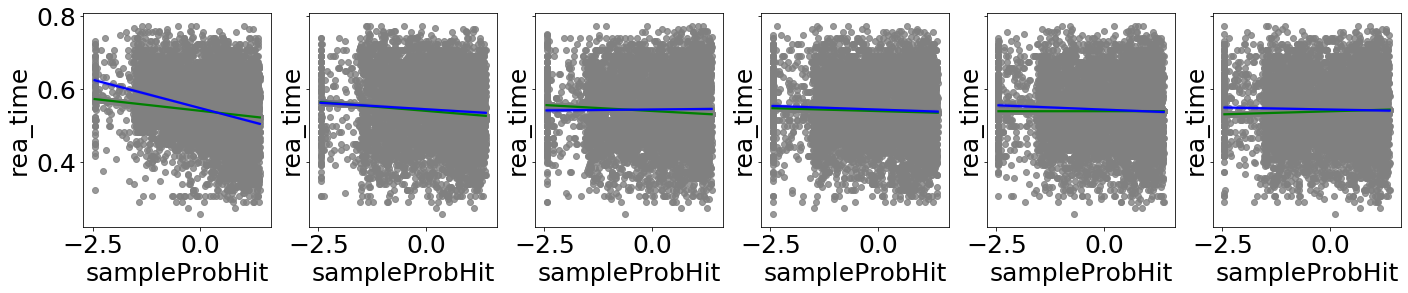

In [23]:
# run the function to plot predictions vs. individual time windows
plotting.plot_prediction_comparison(ldf_go_normal, rts_r1, 'rea_time', order = 1)

The model clearly does not fit the correlation in the first time window. Other time windows also show a clear
missmatch between the correlation as predicted based on single time windows and the predictions based on the model.
This motivates us to fit a model with individual regressors for each time window.

By doing so, we will exclude the main effect of time that was significant in the model above. 
However, we believe that the significance of the main effect of time is an artefact cause by the
bad fit of the interaction term. 

We would not expect a main effect of time in this model, because the same temporal structure of 
stimuli appearance was repeated in each trial.

In [24]:
rtsSample_full = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 + hitGoal +(1|subject)', 
                      data = sdf_go_normal)
rtsSample_full.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+hitGoal+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5568.388 	 AIC: -11136.776

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.535,0.471,0.598,0.032,3.110,16.488,0.000,***
sampleProbHit_01,-0.027,-0.029,-0.025,0.001,4739.092,-22.845,0.000,***
sampleProbHit_02,-0.003,-0.005,-0.001,0.001,4739.042,-2.450,0.014,*
sampleProbHit_03,0.006,0.003,0.008,0.001,4739.006,4.428,0.000,***
sampleProbHit_04,0.001,-0.001,0.004,0.001,4739.009,1.003,0.316,
sampleProbHit_05,-0.000,-0.003,0.002,0.001,4739.014,-0.292,0.771,
sampleProbHit_06,0.003,0.000,0.005,0.001,4739.004,1.990,0.047,*
hitGoal,0.007,-0.003,0.017,0.005,4739.057,1.307,0.191,


In [25]:
rtsSample_m1 = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_06 + (1|subject)', 
                    data = sdf_go_normal)
rtsSample_m1.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_06+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5582.213 	 AIC: -11164.427

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.540,0.477,0.603,0.032,3.000,16.821,0.000,***
sampleProbHit_01,-0.026,-0.028,-0.024,0.001,4742.135,-23.509,0.000,***
sampleProbHit_02,-0.002,-0.004,0.000,0.001,4742.072,-1.897,0.058,.
sampleProbHit_03,0.007,0.004,0.009,0.001,4742.039,5.758,0.000,***
sampleProbHit_06,0.003,0.001,0.006,0.001,4742.005,2.987,0.003,**


In [26]:
rtsSample_linearmodel = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_03 + sampleProbHit_06 + (1|subject)', 
                             data = sdf_go_normal)
rtsSample_linearmodel.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_03+sampleProbHit_06+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5586.294 	 AIC: -11172.588

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.540,0.477,0.603,0.032,3.000,16.778,0.000,***
sampleProbHit_01,-0.026,-0.028,-0.024,0.001,4743.136,-23.532,0.000,***
sampleProbHit_03,0.006,0.004,0.008,0.001,4743.046,5.571,0.000,***
sampleProbHit_06,0.003,0.001,0.005,0.001,4743.013,2.689,0.007,**


In [27]:
# one model for the figure with all time windows, but without hitGoal

rtsSample_figuremodel = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 + (1|subject)', 
                             data = sdf_go_normal)
rtsSample_figuremodel.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5571.889 	 AIC: -11143.778

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.540,0.477,0.603,0.032,3.000,16.816,0.000,***
sampleProbHit_01,-0.026,-0.029,-0.024,0.001,4740.110,-23.357,0.000,***
sampleProbHit_02,-0.002,-0.005,-0.000,0.001,4740.059,-2.146,0.032,*
sampleProbHit_03,0.006,0.004,0.008,0.001,4740.029,5.276,0.000,***
sampleProbHit_04,0.002,-0.000,0.004,0.001,4740.005,1.570,0.116,
sampleProbHit_05,0.000,-0.002,0.003,0.001,4740.026,0.191,0.848,
sampleProbHit_06,0.003,0.001,0.005,0.001,4740.001,2.630,0.009,**


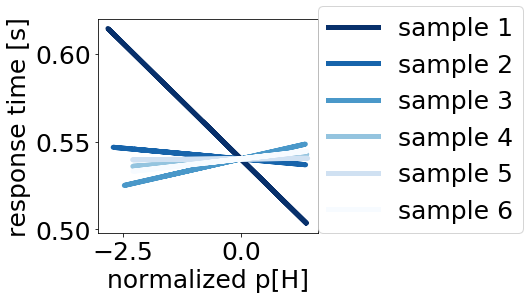

In [28]:
########################################
# Plot the linear reaction times model #
# # # # # # # VVSS  Figure # # # # # # #
########################################
plotting.VVSS2021_fig4_plot(sdf_go_normal, rtsSample_figuremodel)

## 3. Dynamically updating responses

In the following highly visual analysis, I explore what happens if evidence for a given outcome changes between samples.
For this analysis, I compute the proportion of go response for a given change of hit probabilities between two 
adjacent time windows.

The analysis will be conducted in two directions, forward (the go signal being time "0") and backward (the response 
onset being time "0").

In [29]:
######################################
# Get an estimate for reaction times #
# # # # # in no-go  trials # # # # # #
######################################

# in order to have an estimate for reponse times, in no-go-trials, we will assign the mean reaction time to 
# every trial with a no-go response
df_long['nogo_rts'] = utils.get_filled_vec(df_long.copy(), 'rea_time', 'subject')

# get the timing relative to the response instead of the Go signal
df_long['sampleTimeSecResp'] = df_long.sampleTimeSecGo - df_long.nogo_rts

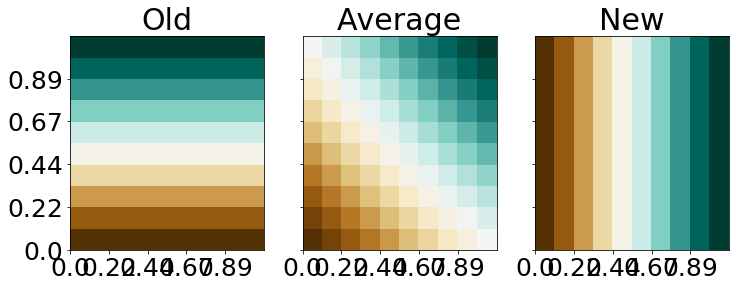

In [30]:
###########################################
# Create the figure with time bin updates #
# # # # # VVSS Code and Figures # # # # # #
###########################################

# what were the responses with a given change?
# compute for different time windows: if the probability changed from x to y - what was the most commonly given answer?
# define the number of time bins, we want to look at:
n_timebin: int = 6
# define the number of probability bins we want to look at
n_probabilitybin = 10

late_illustration, early_illustration = plotting.illustrate_update_response(df_long,n_probabilitybin)

The patterns above illustrate the expected response patterns based on old samples, new samples or an average of them.  Newer information is always shown on the x-axis of the plots, and older information is shown on the y-axis. If a decision is made based on the probability of a hit in the older time window, we should see that more go-responses (green colour) are generated, when the old time window provided evidence for a "hit" above 0.5. Consequently, no-go responses (brown colour) should be generated when the evidence for a hit was below 0.5. The pattern we expect is a division of go/no-go responses along the 0.5 mark of the y-axis. When the decision is based on new information, we would expect to see that division along the 0.5 mark of the y-axis.

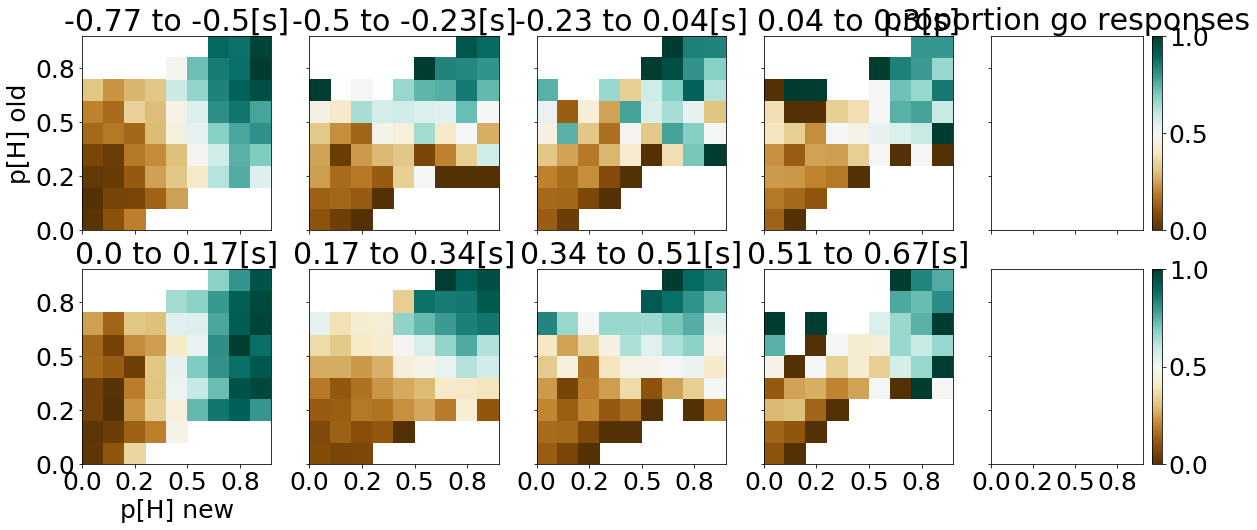

In [31]:
# generate the plot for observer's responses

panelfw, panelbw = plotting.make_update_response_plot(df_long, n_timebin, n_probabilitybin)

In this analysis, we show the proportion of go and no-go responses in a backward oriented manner (0 being the moment the hand started to move, upper row) and in a forward oriented manner (0 being the time of the go-signal, lower row).

The column to the left shows the earliest change between time windows, the column to the right shows the latest change between time windows. The beginning of the two time windows that are compared in each panel is noted in the title of each panel. A time window always ends when the next time window starts. 

E.g. The upper left panel shows how often a "go" response was given when a stimulus shown between 770ms and 500 ms before a hand movement had the hit probability indicated at the y-axis, and the subsequent stimulus, presented between 500 ms and 230 ms before the hand movement had the hit probability indicated on the x-axis.

The plots in the left column show a separation between go- and no-go responses along the x-axis. This indicates that the new information is a better predictor of the response. This clear separation along the x-axis disappears over time and later time points rather suggest a separation along the y-axis even though this pattern is hard to interpret, due to missing values in the upper left and lower right corner of each plot.

##### more comments please on the accumulated probability used here etc.

5. Mechanistic description

Finally, we will fit 3 different drift diffusion models as mechanistic explanations for the behaviour. 
The drift diffusion models vary in terms of their adaptability to novel information.

The first model starts drifting with the very first presented sample and does not adjust it's response after it's drift has started.

The second model only starts drifting after a given threshold for the evidence was crossed but does not change it's response after the drift has started.

The third model start drifting as soon as the first sample was presented and adjusts it's drift rate with every new sample.


We will fit these drift diffusion models using the pyDDM library written by  Maxwell Shinn, Norman H Lam and John D Murray (eLife, 2020) https://pyddm.readthedocs.io/en/latest/index.html

Drift diffusion models fitted with pyDDM have 4 core parameters that can be adjusted to accomodate custom functions. These parameters are: 
1. drift: the drift rate with which the decision value approaches the boundary
2. noise: the noise added to the drift
3. bound: the position of the boundary
4. overlay: any post-drift adaptations to the reaction time distributions.

In the models below, noise, bound and overlay will be the same, only the drift rate will be defined differently.

NOISE: the noise level will be constant throught all trials, the standart deviation will be fitted

BOUND: the bounds will collaps exponentially after a delay. The decay parameter and the delay will be fitted.

OVERLAY: a constant non-decision time is added. The value of that non decision time will be fitted.


The drift rates will be explained in detail when defined.

#### Important to note:
Fitting these models takes a long time. The specific lines that call the fit will be commented out below. 
Due to computational constraints, we will fit the drift diffusion models only to one participant for the purpose of this conference. 

As reaction times are only available for "go" responses, we only fit the response time to go-responses here.
To compare the resulting model fits to the participant, however, we need to generate no-go-responses, too. 

Here is how I will do this:

drift diffusion models track the evidence for one outcome over another. In this implementation, the upper bound represents a "go" outcome, the lower bound represents a "no-go" outcome. To enable negative drift rates, we need to scale our evidence (probability of a hit) such that it centers at zero and has positive and negative evidence values. This is the case for our normalized hit probabilities.

In [39]:
# set up the data frame to model the drift diffusion
# import my file

sample = dda.get_ddm_sample(sdf_go_normal, 'o1', 'goResp')


In [ ]:
ddm1 = dda.fit_save_ddm(sample, 'ddm1', 'ddm1_20_05.pkl')

ddm2 = dda.fit_save_ddm(sample, 'ddm2', 'ddm2_20_05.pkl')

ddm3 = dda.fit_save_ddm(sample, 'ddm3', 'ddm3_20_05.pkl')


Fitting a new model. this will take some time


In [ ]:
ddm1_df = dda.get_ddm_responses(ddm1, sdf_normal, 'o1')
ddm2_df = dda.get_ddm_responses(ddm2, sdf_normal, 'o1')
ddm3_df = dda.get_ddm_responses(ddm3, sdf_normal, 'o1')

In [ ]:
# get response types   
ddm1_df = dda.match_response_types(ddm1_df)
ddm2_df = dda.match_response_types(ddm2_df)
ddm3_df = dda.match_response_types(ddm3_df)

In [ ]:
# make one large plot to compare the model predicitions to the actual data.
data = sdf_normal[sdf_normal.subject == 'o1']
plotting.compare_ddm_to_data(data, ddm1_df, ddm2_df, ddm3_df)

In [38]:
#########################
# Miscellaneous figures #
#########################
#TODO: put in function
# These figures were used to create visualizations of the experiment. 
# After they were build they were modified with Inkscape.

# colorbar for time 
cbar_fig, cbar_ax = plt.subplots(figsize=(3*width, 0.0))
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=colormaps['t_cm'], orientation='horizontal')

cbar_fig.savefig(path_figs + 'SupFig1_timescale.pdf', bbox_inches = 'tight')

# timeline with samples dots
VVSS2021_timecourse, axs_timecourse = plt.subplots(1,1, figsize = (3*width, height))

start = np.round(min(df_long.sampleTimeSecGo), 2) # earliest sample, rounded
end = np.round(max(df_long.sampleTimeSecGo), 2) # latest sample, rounded
n_sample = 6

axs_timecourse.scatter(np.linspace(start, end, n_sample),[1]*n_sample, color = 'black', s = 500)
axs_timecourse.set_xlim(0,1)
axs_timecourse.set_ylabel('samples')
axs_timecourse.set_xlabel('time since go signal [s]')

VVSS2021_timecourse.savefig(path_figs+'SupFig2_timecourse.pdf', bbox_inches = 'tight');

NameError: name 'width' is not defined